# Project 3: Poisonous mushrooms

In this project, you'll investigate properties of mushrooms. This classic dataset contains over 8000 observations, where each mushroom is described by a variety of features like color, odor, etc., and the target variable is an indicator for whether the mushroom is poisonous. Since all the observations are categorical, I've binarized the feature space. Look at the feature_names below to see all 126 binary names.

You'll start by running PCA to reduce the dimensionality from 126 down to 2 so that you can easily visualize the data. In general, PCA is very useful for visualization (though sklearn.manifold.tsne is known to produce better visualizations). Recall that PCA is a linear transformation. The 1st projected dimension is the linear combination of all 126 original features that captures as much of the variance in the data as possible. The 2nd projected dimension is the linear combination of all 126 original features that captures as much of the remaining variance as possible. The idea of dense low dimensional representations is crucial to machine learning!

Once you've projected the data to 2 dimensions, you'll experiment with clustering using KMeans and density estimation with Gaussian Mixture Models. Finally, you'll train a classifier by fitting a GMM for the positive class and a GMM for the negative class, and perform inference by comparing the probabilities output by each model.

As always, you're welcome to work on the project in groups and discuss ideas on the course wall, but please prepare your own write-up and write your own code.

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GMM
from matplotlib.colors import LogNorm

Load feature names.

In [3]:
feature_names = []
with open('../Data/mushroom.map') as fmap:
    for line in fmap:
        [index, name, junk] = line.split()
        feature_names.append(name)

print ('Loaded feature names:', len(feature_names))

Loaded feature names: 126


Load data. The data is sparse in the input file, but there aren't too many features, so we'll use a dense representation, which is supported by all sklearn objects.

In [5]:
X, Y = [], []

with open('../Data/mushroom.data') as fdata:
    for line in fdata:
        items = line.split()
        Y.append(int(items.pop(0)))
        x = np.zeros(len(feature_names))
        for item in items:
            feature = int(item.split(':')[0])
            x[feature] = 1
        X.append(x)

# Convert these lists to numpy arrays.
X = np.array(X)
Y = np.array(Y)

# Split into train and test data.
train_data, train_labels = X[:7000], Y[:7000]
test_data, test_labels = X[7000:], Y[7000:]

# Check that the shapes look right.
print (train_data.shape, test_data.shape)

(7000, 126) (1124, 126)


(1) Run Principal Components Analysis on the data. Show what fraction of the total variance in the training data is explained by the first k principal components, for k in [1, 50].

In [6]:
def P1():
### STUDENT START ###
    pca = PCA(n_components=50)
    pca.fit(train_data)
    print(pca.explained_variance_ratio_.cumsum())
### STUDENT END ###

P1()

[0.16404331 0.2972781  0.39901267 0.46964623 0.50831269 0.54512074
 0.57640313 0.6037405  0.62990541 0.65221483 0.67269656 0.69137987
 0.70872409 0.7255677  0.74075588 0.75584207 0.7701334  0.78425353
 0.79750398 0.80896777 0.81967842 0.83033589 0.84074556 0.85068255
 0.85976325 0.86845651 0.87641268 0.88417092 0.89154662 0.89854938
 0.90496171 0.91110684 0.91683029 0.92216658 0.92742594 0.93245269
 0.9374431  0.94200252 0.94653036 0.95092824 0.95512313 0.95910015
 0.96280057 0.96639586 0.9697771  0.97276696 0.97548727 0.97784433
 0.98005831 0.98210282]


(2) PCA can be very useful for visualizing data. Project the training data down to 2 dimensions and plot it. Show the positive (poisonous) cases in blue and the negative (non-poisonous) in red. Here's a reference for plotting: http://matplotlib.org/users/pyplot_tutorial.html

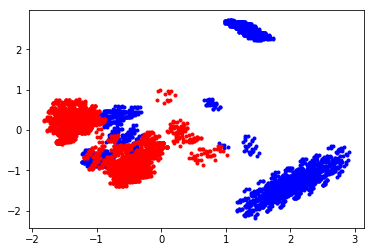

In [7]:
def P2():
### STUDENT START ###
    pca = PCA(n_components=2)
    train_proj = pca.fit(train_data).transform(train_data)
    plt.plot([row[0] for row in train_proj[train_labels==1]], [row[1] for row in train_proj[train_labels==1]], 'b.', \
             [row[0] for row in train_proj[train_labels==0]], [row[1] for row in train_proj[train_labels==0]], 'r.')
    plt.show()
### STUDENT END ###

P2()

(3) Run KMeans with [1,16] clusters over the 2d projected data. Mark each centroid cluster and plot a circle that goes through the most distant point assigned to each cluster.

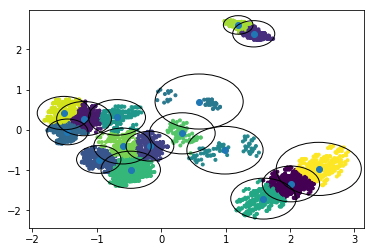

In [8]:
def P3():
### STUDENT START ###
    # get projections
    pca = PCA(n_components=2)
    train_proj = pca.fit(train_data).transform(train_data)
    # fit k-means
    kmeans = KMeans(n_clusters=16, random_state=0)
    # plot points
    plt.scatter(train_proj[:, 0], train_proj[:, 1], c=kmeans.fit_predict(train_proj), marker='.')
    # plot centers
    plt.scatter(kmeans.cluster_centers_[:, 0],kmeans.cluster_centers_[:, 1])
    # find radiuses for circles
    max_dist = [0]*16
    for point,label in zip(train_proj, kmeans.labels_):
        dist = np.linalg.norm(point - kmeans.cluster_centers_[label])
        if max_dist[label] < dist:
            max_dist[label] = dist
    # plot circles
    for i in range(16):
        plt.gcf().gca().add_artist(plt.Circle(kmeans.cluster_centers_[i], max_dist[i], fill=False))
    plt.show()
### STUDENT END ###

P3()

(4) Fit a Gaussian Mixture Model for the positive examples in your 2d projected data. Plot the estimated density contours as shown here: http://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_pdf.html#example-mixture-plot-gmm-pdf-py. Vary the number of mixture components from 1-4 and the covariance matrix type ('spherical', 'diag', 'tied', 'full').

/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:1484: UserWarning: Log scale: values of z <= 0 have been masked
  warnings.warn('Log scale: values of z <= 0 have been masked')


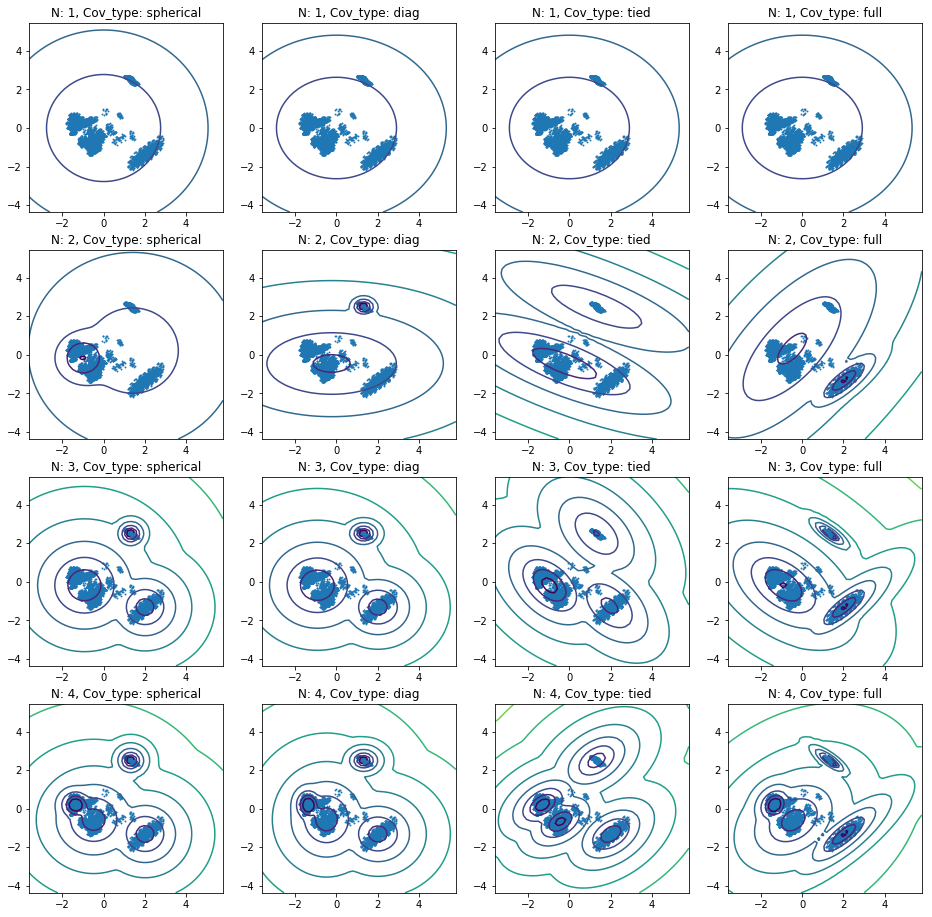

In [9]:
from sklearn import mixture

def P4():
### STUDENT START ###
    # get projections
    pca = PCA(n_components=2)
    train_proj = pca.fit(train_data).transform(train_data)
    cov_type = ('spherical', 'diag', 'tied', 'full')
    # make plots
    f, axarr = plt.subplots(4, 4, figsize=(16, 16))
    for i in range(4):
        for j in range(4):
            # fit Gaussian Mixture
            clf = mixture.GaussianMixture(n_components=i+1, covariance_type=cov_type[j])
            clf.fit(train_proj)
            # display predicted scores by the model as a contour plot
            x = np.linspace(2*min(train_proj[:, 0]), 2*max(train_proj[:, 0]))
            y = np.linspace(2*min(train_proj[:, 1]), 2*max(train_proj[:, 1]))
            X, Y = np.meshgrid(x, y)
            XX = np.array([X.ravel(), Y.ravel()]).T
            Z = -clf.score_samples(XX)
            Z = Z.reshape(X.shape)
            axarr[i, j].contour(X, Y, Z, norm=LogNorm(vmin=1.0, vmax=1000.0), levels=np.logspace(0, 3, 10))
            axarr[i, j].scatter(train_proj[:, 0], train_proj[:, 1], .8)
            axarr[i, j].set_title('N: '+str(i+1)+', Cov_type: '+cov_type[j])
    plt.show()
        
### STUDENT END ###

P4()


(5) Fit two 4-component full covariance GMMs, one for the positive examples and one for the negative examples in your 2d projected data. Predict the test examples by choosing the label for which the model gives a larger probability (use GMM.score). What is the accuracy?

In [10]:
def P5():
### STUDENT START ###
    # get projections
    pca = PCA(n_components=2)
    train_proj = pca.fit(train_data).transform(train_data)
    test_proj = pca.fit(test_data).transform(test_data)
    # fit GMMs 
    clf0 = mixture.GaussianMixture(n_components=4, covariance_type='full', random_state=123456)
    clf0.fit(train_proj[train_labels==0])
    clf1 = mixture.GaussianMixture(n_components=4, covariance_type='full', random_state=123456)
    clf1.fit(train_proj[train_labels==1])
    # find accuracies
    train_pred = [1 if clf0.score(train_proj[i].reshape(1, -1)) < clf1.score(train_proj[i].reshape(1, -1)) else 0 \
                 for i in range(len(train_labels))]
    print('Train accuracy is ', metrics.accuracy_score(train_pred, train_labels))
    test_pred = [1 if clf0.score(test_proj[i].reshape(1, -1)) < clf1.score(test_proj[i].reshape(1, -1)) else 0 \
                 for i in range(len(test_labels))]
    print('Test accuracy is ', metrics.accuracy_score(test_pred, test_labels))
    
    
### STUDENT END ###

P5()

Train accuracy is  0.9435714285714286
Test accuracy is  0.9279359430604982


(6) Ideally, we'd like a model that gives the best accuracy with the fewest parameters. Run a series of experiments to find the model that gives the best accuracy with no more than 50 parameters. For example, with 3 PCA components and 2-component diagonal covariance GMMs, you'd have:

( (3 mean vector + 3 covariance matrix) x 2 components ) x 2 classes = 24 parameters

You should vary the number of PCA components, the number of GMM components, and the covariance type.

In [11]:
def P6():
### STUDENT START ###
    cov_types = ('spherical', 'diag', 'tied', 'full')
    pca_comps = [2,3]
    gmm_comps = [3,4]
    print('Test accuracy:')
    for pca_comp in pca_comps:
        for gmm_comp in gmm_comps:
            for cov_type in cov_types:
                # get projections
                pca = PCA(n_components=pca_comp)
                train_proj = pca.fit(train_data).transform(train_data)
                test_proj = pca.fit(test_data).transform(test_data)
                # fit GMMs 
                clf0 = mixture.GaussianMixture(n_components=gmm_comp, covariance_type=cov_type, random_state=123456)
                clf0.fit(train_proj[train_labels==0])
                clf1 = mixture.GaussianMixture(n_components=gmm_comp, covariance_type=cov_type, random_state=123456)
                clf1.fit(train_proj[train_labels==1])
                # find accuracy
                test_pred = [1 if clf0.score(test_proj[i].reshape(1, -1)) < clf1.score(test_proj[i].reshape(1, -1)) \
                             else 0 for i in range(len(test_labels))]
                print('For ', pca_comp, 'PCA comps, ', gmm_comp, 'GMM comps, and ', cov_type, 'cov type: ', \
                      metrics.accuracy_score(test_pred, test_labels))
                
### STUDENT END ###

P6()

Test accuracy:
For  2 PCA comps,  3 GMM comps, and  spherical cov type:  0.8158362989323843
For  2 PCA comps,  3 GMM comps, and  diag cov type:  0.7873665480427047
For  2 PCA comps,  3 GMM comps, and  tied cov type:  0.6690391459074733
For  2 PCA comps,  3 GMM comps, and  full cov type:  0.8896797153024911
For  2 PCA comps,  4 GMM comps, and  spherical cov type:  0.8629893238434164
For  2 PCA comps,  4 GMM comps, and  diag cov type:  0.9234875444839857
For  2 PCA comps,  4 GMM comps, and  tied cov type:  0.6129893238434164
For  2 PCA comps,  4 GMM comps, and  full cov type:  0.9279359430604982
For  3 PCA comps,  3 GMM comps, and  spherical cov type:  0.6797153024911032
For  3 PCA comps,  3 GMM comps, and  diag cov type:  0.7944839857651246
For  3 PCA comps,  3 GMM comps, and  tied cov type:  0.6156583629893239
For  3 PCA comps,  3 GMM comps, and  full cov type:  0.7562277580071174
For  3 PCA comps,  4 GMM comps, and  spherical cov type:  0.943950177935943
For  3 PCA comps,  4 GMM comps

The best accuracy was found with 3 PCA components and 4-component diagonal covariance GMMs with full covariance type.